In [1]:
#export
import os
import pickle
from dataclasses import dataclass

import cv2
from dataclasses_json import dataclass_json
import ffmpeg
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import skvideo.io
from tqdm import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm


from experiment_utils.constants import *
from experiment_utils.utils import getLogger

ImportError: DLL load failed while importing _ufuncs: The specified module could not be found.

In [4]:
logger = getLogger()

In [5]:
def get_sample_videos_paths():
    return [os.path.join(DATA_DIR, name) for name in os.listdir(DATA_DIR)]

In [6]:
all_vids = get_sample_videos_paths()

In [7]:
def get_video_size(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    width = int(video_info['width'])
    height = int(video_info['height'])
    
    return width, height

def get_video_num_frames(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    
    return int(video_info['nb_frames'])

In [8]:
%%time
# get_all_frames(all_vids[0])

Wall time: 0 ns


## Downsampling

Since the data in it's original format is approx 32G in size, we need to downsample

We can downsample in multiple ways:

1. Framerate
2. Color
3. Frame Size

In [21]:
def get_downsampled_frames(filename: str):
    videogen = skvideo.io.vreader(all_vids[0])

    downsample_width = 640
    downsample_height = 480
    
    downsample_fps_ratio = 4
    
    frames = []
    
    with tqdm(total=get_video_num_frames(filename)) as progress_bar:
        for frame in videogen:
            if progress_bar.last_print_n % downsample_fps_ratio != 0:
                progress_bar.update(1)
                continue
            
            resized_image = resize(frame, (downsample_height, downsample_width))
            rgb_weights = [0.2989, 0.5870, 0.1140]
            grayscale_image = np.dot(resized_image[...,:3], rgb_weights)
            
            int_frame = (grayscale_image * 255).astype(np.uint8)
            
            frames.append(int_frame)
            progress_bar.update(1)
    
    return frames

In [22]:
downsampled_frames = get_downsampled_frames(all_vids[0])

[INFO] 2021-09-25 21:53:42,990 root        : Getting video size for 'E:\\dev\\csgo_clips_autotrim\\data\\1v4.mp4'
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7208/7208 [05:16<00:00, 22.74it/s]


In [23]:
len(downsampled_frames)

1957

In [29]:
data = np.concatenate(downsampled_frames, axis=1)

In [27]:
with open(os.path.join(DATA_DIR, f'downsample_1v4.mp4.pickle'), 'wb') as f:
    pickle.dump(data, f)

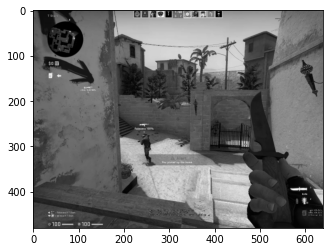

In [31]:
plt.imshow(downsampled_frames[0], cmap='gray')

In [30]:
data.shape

(480, 1252480)